# Purpose
## Building an Interaction between categorical predictors

In McElreath Statistical rethinking 2nd edition [1], Richard discribes how to build interactions between continous and categorical predicatros as well as continous and continous predicators. How do we build a regression model with interactions between two categorical predicators? My first attempt was simply to build the regression using *two intercepts* where each categorical predicator would have their respected mean:

$$ y_i \sim Normal(\mu_i, \sigma)$$
$$\mu_i = \alpha_{factor_A[i]} + \alpha_{factor_B[i]}$$
$$\alpha_{factor_A[j]} \sim  Normal(0, 10)\quad \text{for}\: j = 1...J$$
$$\alpha_{factor_B[k]} \sim  Normal(0, 10)\quad \text{for}\: k = 1...K$$
$$\sigma \sim Exponential(1)$$

Above we are using a index variable for the categories which the approach is also discussed in the book, chapter 5. [1] A more experience practionar might already see the problem with this model definition, but until I built the model I didn't realize the error. I wasn't the only one to think the above model was a reasonable approach, see the post on the PyMC discourse forum titled [Modeling two varying intercepts](https://discourse.pymc.io/t/modeling-two-varying-intercepts/6107) for a spolier.

To be clear, the model definition above is **wrong** to predict a continous variable with two categorical predicator but let's simulate a dataset to see why model definition is incorrect. Lets simulate data that we know doesn't have interactions just to isolate the issue.

```python
import jax.numpy as jnp
from jax.numpy import DeviceArray

import numpyro
import numpyro.distributions as dist

proba_ = 0.28
cpt_ = jnp.array([[0.9, 0.1], [0.2, 0.8]])
mean_ = jnp.array([15.,10.])

def synthetic_00(proba: float, cpt: DeviceArray, mean: DeviceArray):
    A = numpyro.sample("A", dist.Bernoulli(proba))
    M = numpyro.sample("M", dist.Categorical(cpt[A]))
    D = numpyro.sample("D", dist.Normal(mean[A],1))
```

* model render 

The function above simulates a joint probability where A is a common cause of both D and M, and D and M are conditional independent given A. Before fitting we expect that if we regress D on just A we would see one category will have a mean of 15 and another with a mean of 10. 

* pairs plot

We will fit the model using Numpyro. The incorrect model of predicting a continous outcome with two categorical predicators is shown below:

```python
def model_00(
    factor_00: DeviceArray, factor_01: DeviceArray, y: Optional[DeviceArray] = None
):
    num_data = cat_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))

    sigma = numpyro.sample("sigma", dist.Exponential(1))

    with numpyro.plate("num_factor_00", num_factor_00):
        a_factor_00 = numpyro.sample("a_factor_00", dist.Normal(0, 10))

    with numpyro.plate("num_factor_01", num_cat_01):
        b_factor_01 = numpyro.sample("b_factor_01", dist.Normal(0, 10))

    with numpyro.plate("num_data", num_data):
        mu = numpyro.deterministic(
            "mu", a_factor_00[factor_00] + b_factor_01[factor_01]
        )
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)
```

* mcmc.print_summary()
* trace plot

Looking at the trace plots we can see the model converges and don't see any obvious problems with the inference. The problem with this model is multicollinearity. With both means in the model there are infinite combinations of the two parameters that will result in equally good fits to the data such that the sums of the parameters recovers the response between D and A. We can verify the cause by inspecting the correlation of the posterior for the two parameters.

* image of the posterior distribution of the parameters

The plot above shows a significant correlation between the two parameters. Visually inspecting the correlation of the posterior for the parameters is always good practice for your model diagnostics, see [chapter 8 of Course Handouts for Bayesian Data Analysis Class for examples](https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html).

## Wait... How do we build an interaction with a continous outcome and two categorical predicators?

Again more traditionally trained in statistics might already recognize the pattern of our problem as a simple analysis of variance (ANOVA). Our next challenge is how to set up the model using our Bayesian approach. Typical statitical texts develope ANOVA by the decomposition of the variance for each factor through the ANOVA table, but there is an analogous way to setup ANOVA using regression. Aside, most statical test are just linear models, see the post by [Jonas Kristoffer Lindeløv titled Common statistical tests are linear models](https://lindeloev.github.io/tests-as-linear/#6_three_or_more_means). I find the simplest ANOVA model to implement without re-parameterizing the data into a design matrix is the cell means model:

$$Y_{i,j,k} \sim Normal(\mu_{i,j}, \sigma)$$
$$\mu_{i,j} \sim Normal(0,10)$$
$$\sigma \sim Exponential(1)$$
$$i = 1,...,I\: \text{levels of factor}\: I$$
$$j = 1,...,J\: \text{levels of factor}\: J$$
$$k = 1,...,K\: \text{observations in cell}\: (i,j)$$


* Wanted to see how I can build a regression prediciting a continous/metric response using two predictors that are discrete/categorical/factors/nominal
* The large motivation for the exercise is recover known interaction effects between the two predictors
* McElreath [1] shows how to build interactions between continous and categorical, continous and continous, but doesn't show a categorical and categorical
* Using the approach index variables for categorical predicators I tought the model will simply by the additoin of two seperate means
* This approach is incorrest and was similar to [Modeling two varying intercepts](https://discourse.pymc.io/t/modeling-two-varying-intercepts/6107) which introduced multicollinearity


* build a Bayesian Regression with continous output on two categorical predicators
* key is to see if we model categorical predicators as index variables can we recover 2-way interactions

* The data and examples are adopted from reference [2]
* 

1. Ref: McElreath, R., 2018. Statistical rethinking: A Bayesian course with examples in R and Stan. Chapman and Hall/CRC.
2. Ref: (2016). Understanding 2-way Interactions [Online]. University of Virginia Library Research Data Servi. Available at: [data.library.virginia.edu/understanding-2-way-interactions/](data.library.virginia.edu/understanding-2-way-interactions/) (Accessed: 7 October 2021).

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import arviz as az
import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import Predictive
import pandas as pd
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p arviz,jax,matplotlib,numpy,pandas,scipy,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

arviz     : 0.11.2
jax       : 0.2.19
matplotlib: 3.4.3
numpy     : 1.20.3
pandas    : 1.3.2
scipy     : 1.6.2
numpyro   : 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.277-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 242bbd0bfe44e0f50a1cf4a44230b0022e12da42

Git branch: master



In [5]:
num_warmup = 500
num_samples = 1000
num_chains = 4

In [6]:
np.repeat(["male", "female"], 20)

array(['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'female', 'female', 'female',
       'female', 'female', 'female', 'female', 'female', 'female',
       'female', 'female', 'female', 'female', 'female', 'female',
       'female', 'female', 'female', 'female', 'female'], dtype='<U6')

In [7]:
np.tile(np.repeat(["yes", "no"], 10), 2)

array(['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no',
       'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'],
      dtype='<U3')

In [8]:
d_ = dist.Normal(loc=jnp.array([15, 10]))
s_ = d_.sample(jax.random.PRNGKey(2), (10,))
a_ = jnp.hstack([s_[:, 0], s_[:, 1]])

d_ = dist.Normal(loc=jnp.array([10, 15]))
s_ = d_.sample(jax.random.PRNGKey(3), (10,))
b_ = jnp.hstack([s_[:, 0], s_[:, 1]])

In [9]:
np.hstack([a_, b_])

array([16.028805, 11.885336, 15.030622, 14.758674, 13.008297, 14.223126,
       14.046548, 14.473128, 16.696808, 15.785487, 11.594352, 10.422507,
        9.227918,  9.410624, 10.899588,  9.516018,  9.359873, 10.863315,
       11.077128, 10.843179,  9.862843, 11.87744 , 11.219847,  9.797777,
       10.768153, 10.8682  , 10.823442,  9.204437, 11.274723,  8.450657,
       15.576581, 14.113384, 14.788706, 14.206899, 16.21487 , 14.583523,
       15.402359, 15.538119, 16.827414, 13.739226], dtype=float32)

In [10]:
dat = pd.DataFrame(
    {
        "gender": np.repeat(["male", "female"], 20),
        "trt": np.tile(np.repeat(["yes", "no"], 10), 2),
        "resp": np.hstack([a_, b_]),
    }
)

dat["gender"] = dat["gender"].astype("category")
dat["trt"] = dat["trt"].astype("category")

dat.head()

,gender,trt,resp
0,male,yes,16.028805
1,male,yes,11.885336
2,male,yes,15.030622
3,male,yes,14.758674
4,male,yes,13.008297


In [11]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   gender  40 non-null     category
 1   trt     40 non-null     category
 2   resp    40 non-null     float32 
dtypes: category(2), float32(1)
memory usage: 616.0 bytes


In [12]:
dat.groupby("gender").mean()

,resp
gender,
female,12.756930
male,12.457566


In [13]:
dat.groupby("trt").mean()

,resp
trt,
no,12.710279
yes,12.504217


In [14]:
dat.groupby(["trt", "gender"]).mean()

resp
trt gender           
no  female  15.099108
    male    10.321450
yes female  10.414752
    male    14.593683

In [15]:
dat["resp_z_score"] = (dat["resp"] - dat["resp"].mean())/ dat["resp"].std()

In [16]:
dat.groupby(["trt", "gender"])[["resp","resp_z_score"]].mean()

resp  resp_z_score
trt gender                         
no  female  15.099108      0.992680
    male    10.321450     -0.910592
yes female  10.414752     -0.873423
    male    14.593683      0.791334

In [17]:
dat["gender_id"] = dat.gender.cat.codes
dat["trt_id"] = dat.trt.cat.codes

In [18]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   gender        40 non-null     category
 1   trt           40 non-null     category
 2   resp          40 non-null     float32 
 3   resp_z_score  40 non-null     float32 
 4   gender_id     40 non-null     int8    
 5   trt_id        40 non-null     int8    
dtypes: category(2), float32(2), int8(2)
memory usage: 856.0 bytes


In [19]:
def model_00(cat_00, y=None):
    num_data = cat_00.shape[0]
    num_cat_00 = len(set(cat_00))

    sigma = numpyro.sample("sigma", dist.Exponential(1))

    with numpyro.plate("num_cat_00", num_cat_00):
        a_cat_00 = numpyro.sample("a_cat_00", dist.Normal(0, 1000))

    with numpyro.plate("num_data", num_data):
        numpyro.sample("obs", dist.Normal(a_cat_00[cat_00], sigma), obs=y)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5175.25it/s, 7 steps of size 8.26e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
a_cat_00[0]     12.77      0.56     12.77     11.85     13.67   3963.02      1.00
a_cat_00[1]     12.47      0.57     12.47     11.52     13.36   3131.80      1.00
      sigma      2.54      0.30      2.52      2.08      3.02   2804.06      1.00

Number of divergences: 0


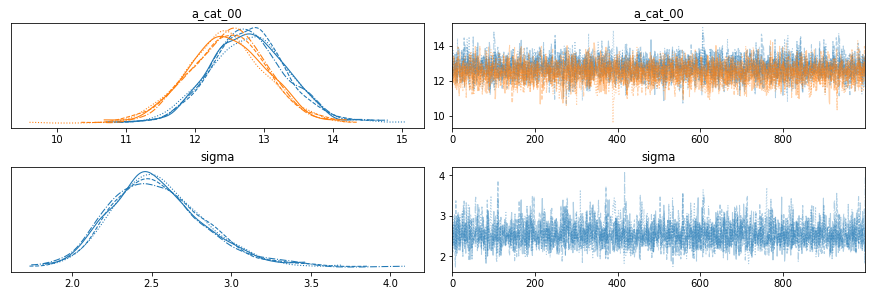

In [20]:
kernel = NUTS(model_00)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(jax.random.PRNGKey(4), jnp.array(dat["gender_id"]), jnp.array(dat["resp"]))
mcmc.print_summary()
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

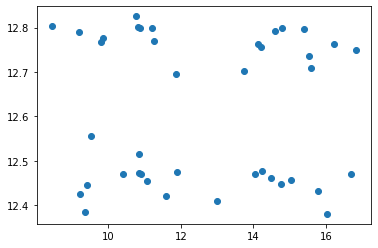

In [21]:
posterior_predictive = Predictive(model_00, mcmc.get_samples())(
    jax.random.PRNGKey(10),
    jnp.array(dat["gender_id"]),
)
fig, ax = plt.subplots()
ax.scatter(dat["resp"], np.array(posterior_predictive["obs"].mean(0)))

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5146.30it/s, 7 steps of size 7.78e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
a_cat_00[0]     12.73      0.56     12.72     11.81     13.66   3593.91      1.00
a_cat_00[1]     12.50      0.57     12.50     11.63     13.51   3104.27      1.00
      sigma      2.54      0.29      2.51      2.06      2.99   3307.47      1.00

Number of divergences: 0


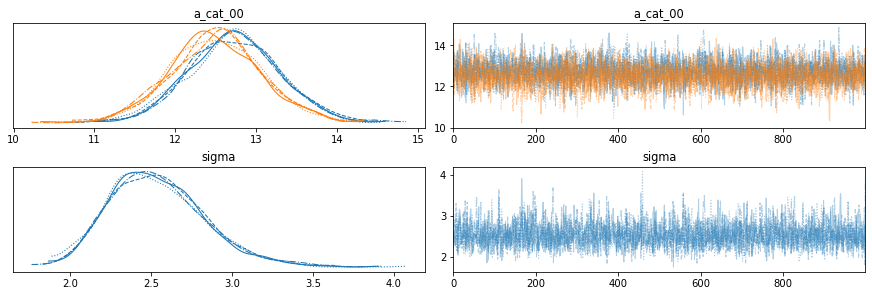

In [22]:
kernel = NUTS(model_00)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(jax.random.PRNGKey(4), jnp.array(dat["trt_id"]), jnp.array(dat["resp"]))
mcmc.print_summary()
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

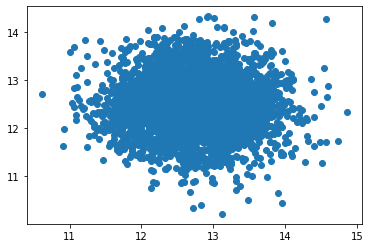

In [23]:
fig, ax = plt.subplots()
ax.scatter(np.array(mcmc.get_samples()["a_cat_00"][:,0]),np.array(mcmc.get_samples()["a_cat_00"][:,1]))

In [24]:
def model_01(cat_00, cat_01, y=None):
    num_data = cat_00.shape[0]
    num_cat_00 = len(set(cat_00))
    num_cat_01 = len(set(cat_01))

    sigma = numpyro.sample("sigma", dist.Exponential(1))

    with numpyro.plate("num_cat_00", num_cat_00):
        a_cat_00 = numpyro.sample("a_cat_00", dist.Normal(0, 0.5))

    with numpyro.plate("num_cat_01", num_cat_01):
        b_cat_01 = numpyro.sample("b_cat_01", dist.Normal(0, 0.5))

    with numpyro.plate("num_data", num_data):
        mu = numpyro.deterministic("mu", a_cat_00[cat_00] + b_cat_01[cat_00])
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5271.27it/s, 7 steps of size 6.76e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
a_cat_00[0]      0.54      0.51      0.54     -0.33      1.32   4467.48      1.00
a_cat_00[1]      0.51      0.50      0.50     -0.35      1.29   4477.30      1.00
b_cat_01[0]      0.51      0.51      0.51     -0.37      1.30   4894.41      1.00
b_cat_01[1]      0.51      0.50      0.52     -0.34      1.29   4308.89      1.00
      sigma     10.75      1.11     10.66      9.03     12.62   4510.70      1.00

Number of divergences: 0


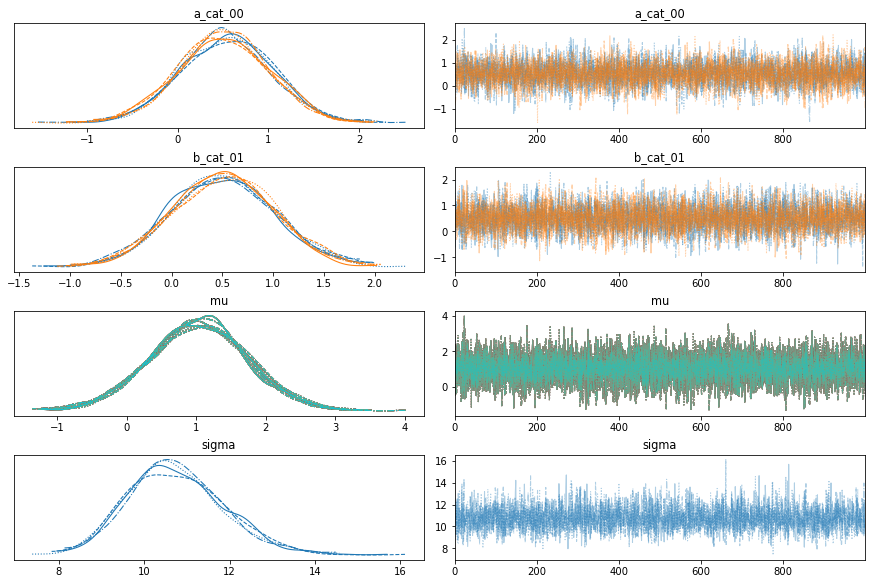

In [25]:
kernel = NUTS(model_01)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(
    jax.random.PRNGKey(4),
    jnp.array(dat["gender_id"]),
    jnp.array(dat["trt_id"]),
    jnp.array(dat["resp"]),
)
mcmc.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5080.93it/s, 7 steps of size 6.76e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
a_cat_00[0]      0.54      0.51      0.54     -0.33      1.32   4467.48      1.00
a_cat_00[1]      0.51      0.50      0.50     -0.35      1.29   4477.30      1.00
b_cat_01[0]      0.51      0.51      0.51     -0.37      1.30   4894.41      1.00
b_cat_01[1]      0.51      0.50      0.52     -0.34      1.29   4308.89      1.00
      sigma     10.75      1.11     10.66      9.03     12.62   4510.70      1.00

Number of divergences: 0


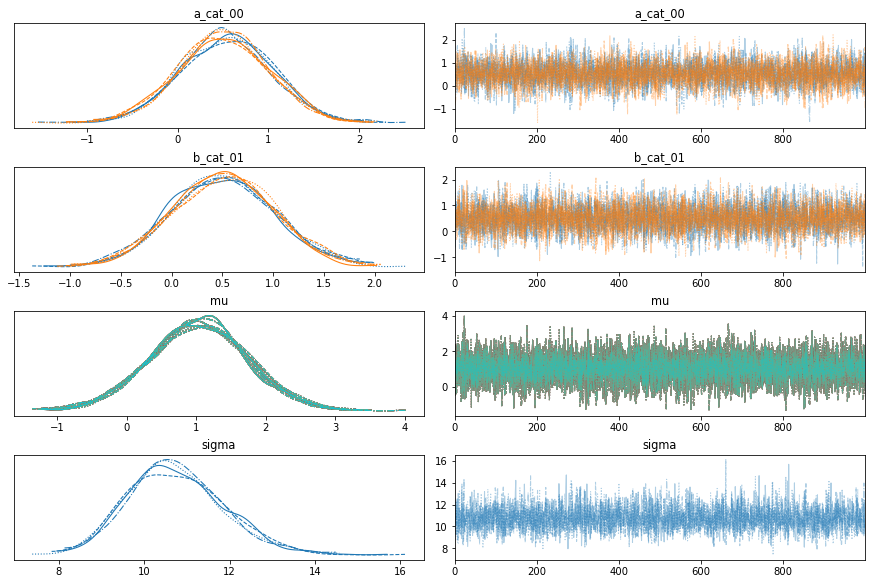

In [26]:
kernel = NUTS(model_01)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(
    jax.random.PRNGKey(4),
    jnp.array(dat["gender_id"]),
    jnp.array(dat["trt_id"]),
    jnp.array(dat["resp"]),
)
mcmc.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

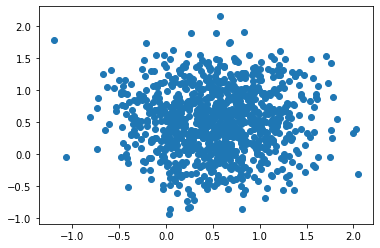

In [27]:
fig, ax = plt.subplots()
ax.scatter(np.array(mcmc.get_samples()["a_cat_00"][:1000,0]), np.array(mcmc.get_samples()["a_cat_00"][:1000,1]))

In [28]:
mcmc.get_samples()["a_cat_00"][:,0]

DeviceArray([0.5657234 , 0.13898987, 0.7552602 , ..., 0.37202257,
             0.35643375, 0.18994337], dtype=float32)

In [29]:
posterior_predictive = Predictive(model_01, mcmc.get_samples())(
    jax.random.PRNGKey(10),
    jnp.array(dat["gender_id"]),
    jnp.array(dat["trt_id"]),
)

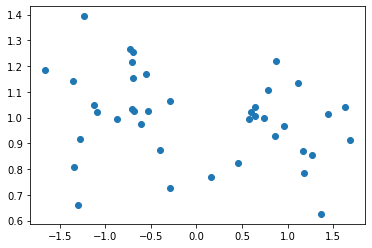

In [30]:
fig, ax = plt.subplots()
ax.scatter(dat["resp_z_score"], np.array(posterior_predictive["obs"].mean(0)))

In [31]:
def model_02(cat_00, cat_01, y=None):
    num_data = cat_00.shape[0]
    num_cat_00 = len(set(cat_00))
    num_cat_01 = len(set(cat_01))
    num_interactions = num_cat_00 * num_cat_01

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    
    grand_mean = numpyro.sample("grand_mean", dist.Normal(0, 0.5))

    with numpyro.plate("num_cat_00", num_cat_00):
        a_cat_00 = numpyro.sample("a_cat_00", dist.Normal(0, 0.5))

    with numpyro.plate("num_cat_01", num_cat_01):
        b_cat_01 = numpyro.sample("b_cat_01", dist.Normal(0, 0.5))
    

    with numpyro.plate("num_data", num_data):
        mu = numpyro.deterministic("mu", grand_mean+ a_cat_00[cat_00] + b_cat_01[cat_00] + a_cat_00[cat_00]*b_cat_01[cat_00])
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 4604.12it/s, 15 steps of size 3.47e-01. acc. prob=0.91]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 a_cat_00[0]      2.36      0.30      2.35      1.86      2.84   2735.59      1.00
 a_cat_00[1]      2.31      0.31      2.30      1.83      2.85   2981.48      1.00
 b_cat_01[0]      2.36      0.30      2.35      1.85      2.83   2987.83      1.00
 b_cat_01[1]      2.32      0.30      2.31      1.81      2.79   2990.71      1.00
  grand_mean      1.43      0.51      1.42      0.64      2.29   3406.10      1.00
       sigma      2.78      0.39      2.73      2.15      3.37   2797.55      1.00

Number of divergences: 0


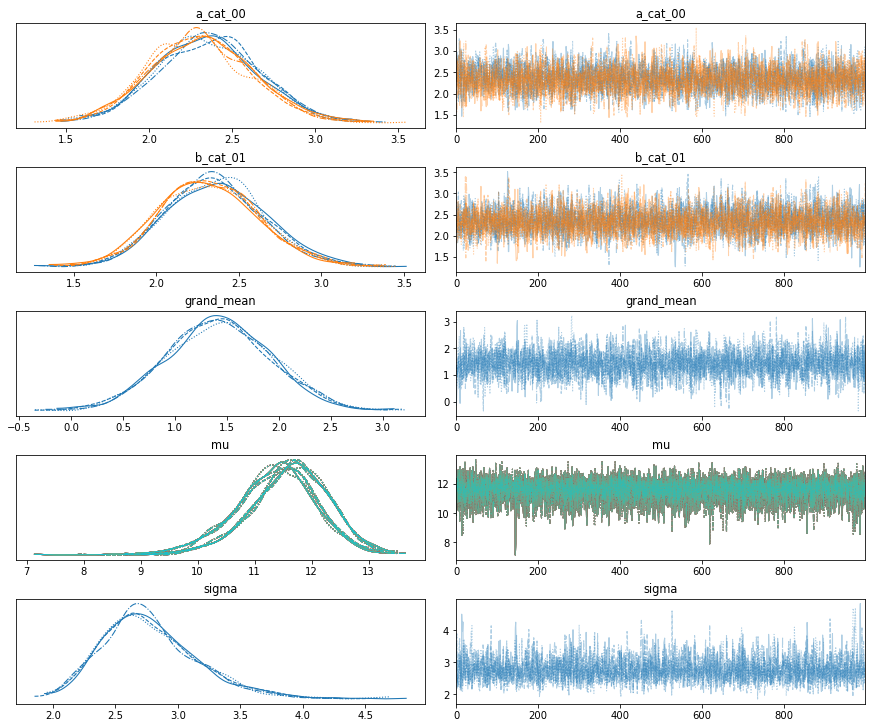

In [32]:
kernel = NUTS(model_02)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(
    jax.random.PRNGKey(4),
    jnp.array(dat["gender_id"]),
    jnp.array(dat["trt_id"]),
    jnp.array(dat["resp"]),
)
mcmc.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

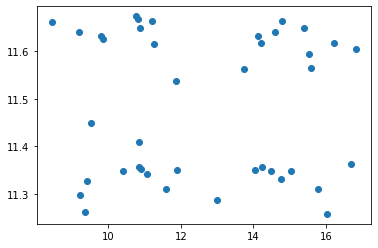

In [33]:
posterior_predictive = Predictive(model_02, mcmc.get_samples())(
    jax.random.PRNGKey(10),
    jnp.array(dat["gender_id"]),
    jnp.array(dat["trt_id"]),
)
fig, ax = plt.subplots()
ax.scatter(dat["resp"], np.array(posterior_predictive["obs"].mean(0)))

In [34]:
def model_04(factor_00, factor_01, y=None):
    num_data = factor_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    
    with numpyro.plate("num_factor_01", num_factor_01):
        with numpyro.plate("num_factor_00", num_factor_00):
            cell_mean = numpyro.sample("cell_mean", dist.Normal(0, 1000))
    
    with numpyro.plate("num_data", num_data):
        numpyro.sample("obs", dist.Normal(cell_mean[factor_00, factor_01], sigma), obs=y)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 4813.77it/s, 7 steps of size 6.52e-01. acc. prob=0.92]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
cell_mean[0,0]     15.09      0.36     15.10     14.51     15.66   4389.89      1.00
cell_mean[0,1]     10.42      0.37     10.42      9.80     10.99   4228.55      1.00
cell_mean[1,0]     10.32      0.35     10.32      9.72     10.88   4261.42      1.00
cell_mean[1,1]     14.60      0.36     14.60     14.01     15.17   4801.05      1.00
         sigma      1.13      0.14      1.12      0.89      1.33   3575.97      1.00

Number of divergences: 0


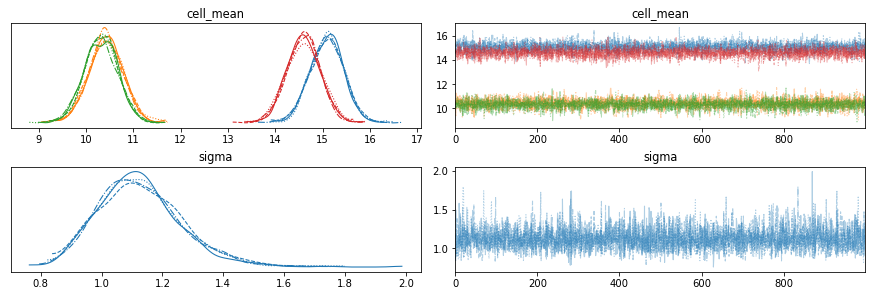

In [35]:
kernel = NUTS(model_04)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(dat["gender_id"]),
    jnp.array(dat["trt_id"]),
    jnp.array(dat["resp"]),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

In [36]:
mcmc_D_A_M.get_samples()["cell_mean"].shape

(4000, 2, 2)

In [37]:
mcmc_D_A_M.get_samples()["cell_mean"].mean(0)

DeviceArray([[15.089465, 10.419379],
             [10.315139, 14.596752]], dtype=float32)

In [38]:
dat.groupby(["trt", "gender"])["resp"].mean().values.reshape(2,2).mean(1)

array([12.710279, 12.504217], dtype=float32)

In [39]:
mcmc_D_A_M.get_samples()["cell_mean"].mean(0).sum(0)

DeviceArray([25.404604, 25.016132], dtype=float32)

In [40]:
mcmc_D_A_M.get_samples()["cell_mean"].mean(0).sum(1)

DeviceArray([25.508844, 24.911892], dtype=float32)

```python
H0: all (μJK – μJ. – μ.K + μ) = 0
```

In [41]:
mcmc_D_A_M.get_samples()["cell_mean"].mean(0) - mcmc_D_A_M.get_samples()["cell_mean"].mean(0).mean(0) - mcmc_D_A_M.get_samples()["cell_mean"].mean(0).mean(1) - mcmc_D_A_M.get_samples()["cell_mean"].mean(0).mean()

DeviceArray([[-22.972443, -27.149817],
             [-27.746769, -22.972443]], dtype=float32)

## Example from Purdue Stat 512

In [42]:
bread = pd.DataFrame(
    {
        "sales": [47, 43, 46, 40, 62, 68, 67, 71, 41, 39, 42, 46],
        "height": [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        "width": [1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2],
    }
)
bread["height_id"] = bread["height"].astype("category").cat.codes
bread["width_id"] = bread["width"].astype("category").cat.codes

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5282.35it/s, 7 steps of size 5.43e-01. acc. prob=0.92]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
cell_mean[0,0]     45.06      2.18     45.07     41.55     48.64   4886.40      1.00
cell_mean[0,1]     43.02      2.20     43.00     39.55     46.64   5130.90      1.00
cell_mean[1,0]     64.96      2.22     65.00     61.45     68.58   4143.56      1.00
cell_mean[1,1]     69.00      2.27     69.01     65.44     72.91   5329.86      1.00
cell_mean[2,0]     39.95      2.15     39.98     36.46     43.40   4646.40      1.00
cell_mean[2,1]     43.97      2.24     43.98     40.21     47.39   4592.48      1.00
         sigma      3.03      0.75      2.91      1.90      4.17   2225.61      1.00

Number of divergences: 0


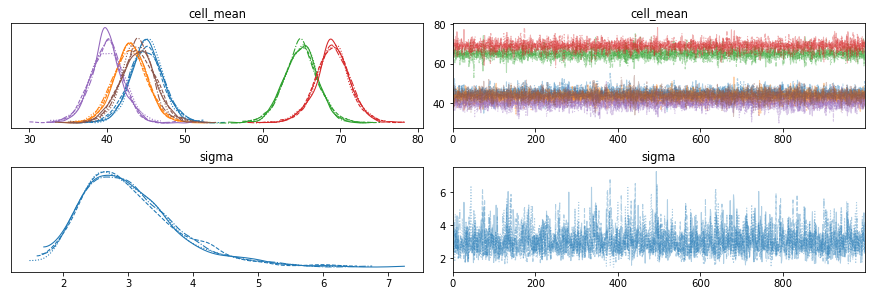

In [43]:
kernel = NUTS(model_04)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(
    jax.random.PRNGKey(4),
    jnp.array(bread["height_id"]),
    jnp.array(bread["width_id"]),
    jnp.array(bread["sales"]),
)
mcmc.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

In [44]:
mcmc.get_samples()["cell_mean"].mean(0)

DeviceArray([[45.058544, 43.01854 ],
             [64.9569  , 68.9969  ],
             [39.952965, 43.96896 ]], dtype=float32)

In [45]:
bread["sales"].mean()

51.0

In [46]:
mcmc.get_samples()["cell_mean"].mean(0).mean()

DeviceArray(50.992138, dtype=float32)

In [47]:
mcmc.get_samples()["cell_mean"].mean(0).mean(1) - mcmc.get_samples()["cell_mean"].mean(0).mean()

DeviceArray([-6.953594 , 15.98476  , -9.0311775], dtype=float32)

In [48]:
mcmc.get_samples()["cell_mean"].mean(0).mean(0) - mcmc.get_samples()["cell_mean"].mean(0).mean()

DeviceArray([-1.0026665,  1.0026627], dtype=float32)

In [49]:
mcmc.get_samples()["cell_mean"].mean(0).mean(0)

DeviceArray([49.98947, 51.9948 ], dtype=float32)

In [50]:
from patsy import dmatrix

In [51]:
bread["height"] = bread["height"].astype("category")
bread["width"] = bread["width"].astype("category")

In [52]:
bread

,sales,height,width,height_id,width_id
0,47,1,1,0,0
1,43,1,1,0,0
2,46,1,2,0,1
3,40,1,2,0,1
4,62,2,1,1,0
5,68,2,1,1,0
6,67,2,2,1,1
7,71,2,2,1,1
8,41,3,1,2,0
9,39,3,1,2,0


In [53]:
d = dmatrix("height*width", bread)
d

DesignMatrix with shape (12, 6)
  Columns:
    ['Intercept',
     'height[T.2]',
     'height[T.3]',
     'width[T.2]',
     'height[T.2]:width[T.2]',
     'height[T.3]:width[T.2]']
  Terms:
    'Intercept' (column 0)
    'height' (columns 1:3)
    'width' (column 3)
    'height:width' (columns 4:6)
  (to view full data, use np.asarray(this_obj))

In [54]:
jnp.array(d)

DeviceArray([[1., 0., 0., 0., 0., 0.],
             [1., 0., 0., 0., 0., 0.],
             [1., 0., 0., 1., 0., 0.],
             [1., 0., 0., 1., 0., 0.],
             [1., 1., 0., 0., 0., 0.],
             [1., 1., 0., 0., 0., 0.],
             [1., 1., 0., 1., 1., 0.],
             [1., 1., 0., 1., 1., 0.],
             [1., 0., 1., 0., 0., 0.],
             [1., 0., 1., 0., 0., 0.],
             [1., 0., 1., 1., 0., 1.],
             [1., 0., 1., 1., 0., 1.]], dtype=float32)

In [55]:
def model_05(X, y=None):
    
    num_data = X.shape[0]
    num_feature = X.shape[1]
    
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    
    with numpyro.plate("num_feature", num_feature):
        beta = numpyro.sample("beta", dist.Normal(0, 1000))
    
    with numpyro.plate("num_data", num_data):
        mu = jnp.sum(beta * X, axis=-1)
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 4849.93it/s, 15 steps of size 2.25e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     45.05      2.21     45.02     41.31     48.58   1070.89      1.01
   beta[1]     20.03      3.17     20.10     15.11     25.10   1213.50      1.01
   beta[2]     -5.06      3.19     -4.98    -10.40     -0.15   1149.09      1.00
   beta[3]     -2.04      3.14     -2.02     -7.17      3.02   1043.42      1.01
   beta[4]      5.98      4.49      5.93     -1.36     13.08   1258.12      1.00
   beta[5]      6.14      4.51      6.00     -1.06     13.33   1318.22      1.00
     sigma      3.06      0.79      2.92      1.90      4.16   1200.81      1.00

Number of divergences: 0


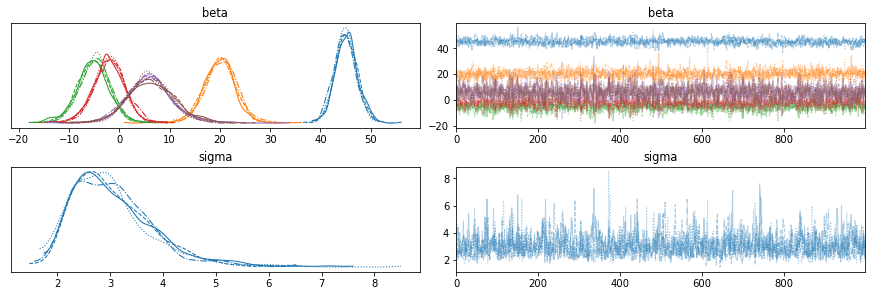

In [56]:
kernel = NUTS(model_05)
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc.run(
    jax.random.PRNGKey(4),
    jnp.array(d),
    jnp.array(bread["sales"]),
)
mcmc.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);